In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
from statsmodels.tsa.x13 import x13_arima_analysis
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
import os
import gc

In [3]:
### RUN ONLY WHEN ARIMA X13 SA LAUNCHING 

### Warnings hiding:
import warnings
warnings.filterwarnings('ignore')
### Seasonal adjustment module paths set up:
%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [4]:
### VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('python version: ', python_version())

pandas version:  2.1.4
numpy version:  1.26.3
python version:  3.11.5


In [5]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
### General daily-mode and ranges initialization:
str_date_data_start = '1984-12-31' ### Start date for data loading
str_date_factor_start = '1989-12-31' ### Start date for factor calculation
str_date_factor_end = '2020-08-31' ### End date for factor calculation
idx_data_range = pd.date_range(str_date_data_start, str_date_factor_end, freq = 'B') ### Range for source data filtering
idx_test_monthly_range = pd.date_range(str_date_factor_start, str_date_factor_end, freq = 'BM') ### Range for loop
idx_test_daily_range = pd.date_range(str_date_factor_start, str_date_factor_end, freq = 'B') ### Range for loop
### Intermediate files:
str_path_bb_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_ant_daily.h5'
str_path_bb_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_yoy_daily.h5'
str_path_regions_hdf = 'Data_Files/Source_Files/Matrix_Regions_daily.h5'
str_path_subs_hdf = 'Data_Files/Source_Files/Matrix_Sub_daily.h5'
str_path_global_hdf = 'Data_Files/Source_Files/Matrix_Global_daily.h5'
str_key_matrix_z = 'matrix_cube_z_scored'
### Results saving paths:
str_path_ei_main_csv = 'Data_Files/Result_Files/ei_main.csv'
str_path_ei_inf_csv = 'Data_Files/Result_Files/ei_inf.csv'

In [6]:
### RUN EVERY TIME: LIST OF DATES LIMITATION

### Data loading : Need to be replaced by SQL Request
str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices_Acadian.h5'
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings ([Index_Name -> Data_Date -> Observation_Date] | Index_Value series)    
ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
idx_test_daily_range = idx_test_daily_range.intersection(ser_history_bday.index.levels[2])

In [7]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_matrix_hdf, str_date):
    ### Vector for nearest date:        
    ser_z_scored = pd.read_hdf(str_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
    ### Extracting data for max date less or equal to needed date:
    ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])

In [8]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS

def columns_average(df_series, list_weights = None): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if list_weights is None:
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [9]:
### DEFINING EXPONENTIAL WEIGHT

def exp_weight_single(halflife_len = 3, num_element = 0):
    ### Weight calculating:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    ### Result output:
    return num_weight

In [10]:
### DEFINING WEIGHTED AVERAGE

def weighted_average(ser_data, ser_weight = False, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if isinstance(ser_weight, bool):
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [11]:
### DEFINING DAILY ANTICIPATION EI TRANSFORMATION TO MATRIX STRUCTURE

def ei_transformation_ant(iter_date):
    ### Transformation options:
    int_min_years_z_score = 3
    ### Z-scoring options:
    int_winsorize_bound = 4
    flo_winsorize_tolerance = 0.0001
    int_winsorize_steps_limit = 5
    def complex_transform(ser_name, df_flags, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
        ### X13 ARIMA Seasonality adjustment model:
        def perform_x13_sa(ser_date):
            ### Dropping constant level:        
            ser_result = ser_date
            ### Check for not empty vector:
            if (ser_result.count() > 0):
                ### Check for minimal quantity of observations to perform seasonality adjustment:
                if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                    ### Naming series for x13 performing:
                    ser_result.name = 'Ticker'
                    ### Calculating shift value to make all series positive:
                    flo_positron = abs(ser_result.min()) * 2
                    try:
                        ### Performing seasonality adjustment:
                        ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
                        print('SA success : ', iter_date)                 
                    except Exception as error:
                        print('SA error : ', str_index_name, ' : ', iter_date, ' : ', type(error).__name__)
                        pass
            ### Results output: 
            return ser_result    
        ### Defining time-vector z-scoring procedure:    
        def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                            str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag):
            ### Check for empty vector (doing nothing):
            if ser_date.count():
                ### Check for non-constant vector:
                if (ser_date.std() > flo_tolerance):
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index() - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):   
                        ### Calculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                        bool_to_winsor = True   
                        int_iter = 1
                        while (bool_to_winsor): 
                            int_iter += 1                
                            ### Value based winsorization:                
                            ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                            ### Recalculating of z scores:
                            ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                            ### Checking for boundaries and steps:
                            if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                                bool_to_winsor = False
                        ### Checking if rebasing needed:
                        if (bool(str_basis_index) & bool_rebase_flag):
                            ### Extracting column from z-scored basis ticker series:
                            str_obs_date = iter_date.strftime('%Y-%m-%d')
                            ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date)
                            ### Selecting only intersected time interval:
                            display(ser_date)
                            ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index() : ]
                            display(ser_basis_part)
                            display(ser_basis_part.std())
                            display(ser_basis_part.mean())
                            ### Rebasing ticker:
                            ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                            display(ser_date)
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
                else:
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index() - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):             
                        ### Constant values demeaning:
                        ser_date = ser_date - ser_date.mean()
                        ### Checking if rebasing needed:
                        if (bool(str_basis_index) & bool_rebase_flag):
                            ### Extracting column from z-scored basis ticker series:
                            str_obs_date = iter_date.strftime('%Y-%m-%d')               
                            ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date)
                            ### Selecting only intersected time interval:
                            display(ser_date)
                            ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index() : ]
                            display(ser_basis_part)
                            ### Rebasing ticker:
                            ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
            ### Memory optimization:
            ser_date = ser_date.astype('float32')
            return ser_date                
        ### EI name extracting:
        str_index_name = ser_name.index.get_level_values(0)[0]    
        print(str_index_name)
        ### Taking last available observation for each Data Dae:
        ser_last = ser_name.groupby('Data_Date').last()
        ### Flags extracting:
        ser_flags = df_flags.loc[str_index_name, All].squeeze()  
        ### 'TAR' type checking:
        if (ser_flags['Type_Prime'] == 'TAR'):
            print(str_index_name, ': TAR Primary Type ignoring')        
            pass
        ### Flags-based transforming:
        else:
            ### Indices of NA values collecting:
            idx_isna = ser_last.loc[ser_last.isna()].index
            ### Transforming to stock-like series:
            ser_stock = ser_last  
            ### Seasonality adjustment:
            if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
#                print(str_index_name, ': Seasonality adjustment')            
                ### Filling empty values:            
                ser_stock = ser_stock.ffill()                  
                ser_stock = perform_x13_sa(ser_stock)                            
                ### Dropping NA values:
                ser_stock.loc[idx_isna] = np.NaN  
            ### Debasing:
#            print(str_index_name, ': Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
            ser_ant.name = 'MoM'
            ### Negative flag check:
            if (ser_flags['Negative'] == 1):
                ser_ant = -ser_ant
            ### Z-scoring across the observation dates:
            ### Adjusting Z-score period limit for some groups:
            if (ser_flags['Data_Source'] == 'Markit'):
                int_min_years_adj = int_min_years_z_score - 1
            else:
                int_min_years_adj = int_min_years_z_score    
            ### Z-score tranformation:
#            print(str_index_name, ': Z-Scoring')             
            ser_ant_z = by_date_z_score(ser_ant, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                        str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'])                   
            ### Adding results to matrix cube:
            ser_ant_z = pd.concat([pd.concat([ser_ant_z], keys = [iter_date], names = ['Observation_Date'])], keys = [str_index_name], names = ['Index_Name'])
            ser_ant_z = ser_ant_z.swaplevel(1, 2).sort_index()              
            ser_ant_z.to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a', 
                             min_itemsize = {'Index_Name': int_max_name_length})    
        ### Results output:
        return ser_ant_z
    ### Flags loading : Need to be replaced by SQL Request
    str_path_flags = 'Data_Files/Source_Files/Flags_For_Production.xlsx'
    df_flags_full = pd.read_excel(str_path_flags, index_col = [0], header = [0])
    df_flags_ant = df_flags_full[(df_flags_full['Type_Prime'] == 'ANT') & (df_flags_full['Processing'] == 'Index')]\
                            .sort_values(['Basic_Ticker'], na_position = 'first')
    ### Data loading : Need to be replaced by SQL Request
    str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices_Acadian.h5'
    str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings ([Index_Name -> Data_Date -> Observation_Date] | Index_Value series)    
    ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
    ### Maximum length calculating (for HDF manipulations):
    int_max_name_length = max(ser_history_raw.index.levels[0].str.len())    
    ### Filtering Indices and Observation Dates limitation:
    ser_history_raw = ser_history_raw.reindex(df_flags_ant.index, level = 'Index_Name').loc[:, :, : iter_date]    
    ### Moving all dates to tne nearest Business day:
    df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
    df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
    ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
    ### Transformation of data vectors:
#    list_test_ei = ['CONCCONF Index','COMFCOMF Index', 'CONSSENT Index']
#    list_test_ei = ['EUBCI Index', 'EUICEMU Index', 'EUSCEMU Index']   
#    list_test_ei = ['ITSR1B Index', 'MPMIGBSA Index']
#    ser_transformed = ser_history_bday[list_test_ei].groupby('Index_Name', group_keys = False, sort = False)\
#                                                    .apply(complex_transform, df_flags_ant, int_min_years_z_score, str_path_bb_matrix_ant_hdf, True)
    ser_transformed = ser_history_bday.groupby('Index_Name', group_keys = False, sort = False)\
                                      .apply(complex_transform, df_flags_ant, int_min_years_z_score, str_path_bb_matrix_ant_hdf, True)    
    ### Results output:
#    return ser_transformed

In [12]:
### DEFINING DAILY NON-ANTICIPATION EI TRANSFORMATION TO MATRIX STRUCTURE

def ei_transformation_yoy(iter_date):
    ### Transformation options:
    int_min_years_z_score = 3
    ### Z-scoring options:
    int_winsorize_bound = 4
    flo_winsorize_tolerance = 0.0001
    int_winsorize_steps_limit = 5
    ### Cumprod shifts for data frequency:
    dict_cumprod_step = {}
    dict_cumprod_step['MoM%'] = 1
    dict_cumprod_step['QoQ%'] = 3
    dict_cumprod_step['YoY%'] = 12
    ### Stock-like series shifts for YoY transformation:
    dict_yoy_shift = {}
    dict_yoy_shift['Monthly'] = 12
    dict_yoy_shift['Quarterly'] = 4
    dict_yoy_shift['Other'] = 52    
    def complex_transform(ser_name, df_flags, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Period-over-period-percent ticker values transforming to stock-like series:
        def pop_to_level(ser_date, int_step):
            ### Dropping constant level:
            ser_result = ser_date
            ### Basis initiating:
            flo_basement = 1.0
            ### Factor initiating: 
            flo_next_brick  = 1.0
            ### Looping over month numbers:
            for iter_period in range(min(int_step, len(ser_result.index))):         
                ### Basement building up:
                flo_basement = flo_basement * flo_next_brick
                ### Next basement brick producing:
                flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
                ### Jumping cumulative product performing:
                idx_iter_data = ser_result.index[iter_period :: int_step]
                ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
            ### Results output:            
            return ser_result            
        ### X13 ARIMA Seasonality adjustment model:
        def perform_x13_sa(ser_date):
            ### Dropping constant level:        
            ser_result = ser_date
            ### Check for not empty vector:
            if (ser_result.count() > 0):
                ### Check for minimal quantity of observations to perform seasonality adjustment:
                if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                    ### Naming series for x13 performing:
                    ser_result.name = 'Ticker'
                    ### Calculating shift value to make all series positive:
                    flo_positron = abs(ser_result.min()) * 2
                    try:
                        ### Performing seasonality adjustment:
                        ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
    #                    print('SA success : ', iter_date)                 
                    except Exception as error:
                        print('SA error : ', str_index_name, ' : ', iter_date, ' : ', type(error).__name__)
                        pass
            ### Results output:                
            return ser_result    
        ### Defining time-vector z-scoring procedure:    
        def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                            str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag):
            ### Check for empty vector (doing nothing):
            if ser_date.count():
                ### Check for non-constant vector:
                if (ser_date.std() > flo_tolerance):
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index() - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):   
                        ### Calculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                        bool_to_winsor = True   
                        int_iter = 1
                        while (bool_to_winsor): 
                            int_iter += 1                
                            ### Value based winsorization:                
                            ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                            ### Recalculating of z scores:
                            ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                            ### Checking for boundaries and steps:
                            if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                                bool_to_winsor = False
                        ### Checking if rebasing needed:
                        if (bool(str_basis_index) & bool_rebase_flag):
                            ### Extracting column from z-scored basis ticker series:
                            str_obs_date = iter_date.strftime('%Y-%m-%d')
                            ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date)
                            ### Selecting only intersected time interval:
                            ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index() : ]
                            ### Rebasing ticker:
                            ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
                else:
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index() - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):             
                        ### Constant values demeaning:
                        ser_date = ser_date - ser_date.mean()
                        ### Checking if rebasing needed:
                        if (bool(str_basis_index) & bool_rebase_flag):
                            ### Extracting column from z-scored basis ticker series:
                            str_obs_date = iter_date.strftime('%Y-%m-%d')               
                            ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date)
                            ### Selecting only intersected time interval:
                            ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index() : ]
                            ### Rebasing ticker:
                            ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
            ### Memory optimization:
            ser_date = ser_date.astype('float32')
            return ser_date                
        ### EI name extracting:
        str_index_name = ser_name.index.get_level_values(0)[0]   
        print(str_index_name)
        ### Taking last available observation for each Data Date:
        ser_last = ser_name.groupby('Data_Date').last()
        ### Flags extracting:
        ser_flags = df_flags.loc[str_index_name, All].squeeze()  
        ### 'TAR' type checking:
        if (ser_flags['Type_Prime'] == 'TAR'):
#            print(str_index_name, ': TAR Primary Type ignoring')        
            pass
        ### Flags-based transforming:
        else:
            ### Indices of NA values collecting:
            idx_isna = ser_last.loc[ser_last.isna()].index
            ### Transforming to stock-like series:
            if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
                ser_stock = ser_last
            elif (ser_flags['Processing'] == 'Flow'):
#                print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
                ### Filling empty values:
                ser_last = ser_last.fillna(0)
                ### Cumulative sum for each observation date calculating:
                ser_stock = ser_last.cumsum()
                ### Dropping NA values:
                ser_stock.loc[idx_isna] = np.NaN
            else:
#                print(str_index_name, ': Transformation to stock-like series: Cumulative product')
                ### Filling empty values:
                ser_last = ser_last.fillna(0)
                ### Percents to multipliers converting:
                ser_stock = 1 + ser_last / 100
                ### Calculating with needed periodicity:
                if (ser_flags['Frequency'] == 'Monthly'):
                    int_step = dict_cumprod_step[ser_flags['Processing']]
                    ### Period-by-period cumprod with rebasing:
                    ser_stock = pop_to_level(ser_stock, int_step)
                ### Dropping NA values:
                ser_stock.loc[idx_isna] = np.NaN            
            ### Seasonality adjustment:
            if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
#                print(str_index_name, ': Seasonality adjustment')            
                ### Filling empty values:            
                ser_stock = ser_stock.ffill()    
                ser_stock = perform_x13_sa(ser_stock)
                ### Dropping NA values:
                ser_stock.loc[idx_isna] = np.NaN    
            ### Transforming to PoP series:
            if (ser_flags['Processing'] == 'Index'):
                ### Debasing only:
#                print(str_index_name, ': Transformation to YoY series: Debasing')            
                ser_yoy = ser_stock - ser_flags['Base']           
            elif (ser_flags['Processing'] in ['Flow', 'Level']):    
                ### Simple difference:
#                print(str_index_name, ': Transformation to YoY series: Simple difference')
                ### Shifting lag defining:
                if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                    int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
                else:
                    int_yoy_shift = dict_yoy_shift['Other']            
                ### Stock-like series differing:
                ser_yoy = ser_stock - ser_stock.shift(int_yoy_shift)
            else:      
                ### Difference with dividing:
#                print(str_index_name, ': Transformation to YoY series: Difference with dividing')
                ### Shifting lag defining:
                if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                    int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
                else:
                    int_yoy_shift = dict_yoy_shift['Other']
                ### Stock-like series differing:
                ser_yoy = ser_stock / ser_stock.shift(int_yoy_shift) - 1               
            ser_yoy.name = 'YoY'
            ### Negative flag check:
            if (ser_flags['Negative'] == 1):
                ser_yoy = -ser_yoy
            ### Z-scoring across the observation dates:
            ### Adjusting Z-score period limit for some groups:
            if (ser_flags['Data_Source'] == 'Markit'):
                int_min_years_adj = int_min_years_z_score - 1
            else:
                int_min_years_adj = int_min_years_z_score    
            ### Z-score tranformation:
#            print(str_index_name, ': Z-Scoring')                        
            ser_yoy_z = by_date_z_score(ser_yoy, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                        str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'])       
            ### Adding results to matrix cube:
            ser_yoy_z = pd.concat([pd.concat([ser_yoy_z], keys = [iter_date], names = ['Observation_Date'])], keys = [str_index_name], names = ['Index_Name'])
            ser_yoy_z = ser_yoy_z.swaplevel(1, 2).sort_index()
            ser_yoy_z.to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a', 
                             min_itemsize = {'Index_Name': int_max_name_length})    
            ### Results output:
            return ser_yoy_z
    ### Flags loading : Need to be replaced by SQL Request
    str_path_flags = 'Data_Files/Source_Files/Flags_For_Production.xlsx'
    df_flags_full = pd.read_excel(str_path_flags, index_col = [0], header = [0])
    df_flags_other = df_flags_full[(df_flags_full['Type_Prime'] != 'ANT') & (df_flags_full['Processing'] != 'Index')]\
                            .sort_values(['Basic_Ticker'], na_position = 'first')
    ### Data loading : Need to be replaced by SQL Request
    str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Eco_Indices_Acadian.h5'
    str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings ([Index_Name -> Data_Date -> Observation_Date] | Index_Value series)    
    ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
    ### Maximum length calculating (for HDF manipulations):
    int_max_name_length = max(ser_history_raw.index.levels[0].str.len())    
    ### Filtering Indices and Observation Dates limitation:
    ser_history_raw = ser_history_raw.reindex(df_flags_other.index, level = 'Index_Name').loc[:, :, : iter_date]    
    ### Moving all dates to tne nearest Business day:
    df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
    df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
    ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
    ### Transformation of data vectors:
#    list_test_ei = ['EUPPEMUM Index', 'ESPPIMOM Index', 'SPROCHNG Index']   
#    idx_test = pd.Index(list_test_ei).intersection(ser_history_bday.index.levels[0], sort = False)
#    ser_transformed = ser_history_bday.loc[idx_test].groupby('Index_Name', group_keys = False, sort = False)\
#                                                    .apply(complex_transform, df_flags_other, int_min_years_z_score, str_path_bb_matrix_yoy_hdf, True)
    ser_transformed = ser_history_bday.groupby('Index_Name', group_keys = False, sort = False)\
                                      .apply(complex_transform, df_flags_other, int_min_years_z_score, str_path_bb_matrix_yoy_hdf, True)
    
    ### Results output:
    return ser_transformed

In [13]:
### RUN TO AGGREGATE: GROUP DATA CONSOLIDATION

def aggregation_by_region(iter_date):
    ### Data filling limit for Regions consolidation
    int_fill_limit = 20
    ### Transformation options:
    int_min_years_z_score = 3
    ### Z-scoring options:
    int_winsorize_bound = 4
    flo_winsorize_tolerance = 0.0001
    int_winsorize_steps_limit = 5
    ### Defining group aggregation function:
    def group_aggregate(ser_group_list, ser_matrix_daily, str_path_regions_hdf):
        def conditional_fill(ser_ticker, int_limit = int_fill_limit):
            ### Category loading:
            str_category = df_flags_full.loc[ser_ticker.index[0][0], 'Category']
            if (str_category == 'Leading'):
                ser_filled = ser_ticker.ffill(limit = int_limit)
            else:
                ser_filled = ser_ticker.bfill(limit = int_limit).ffill(limit = int_limit)
            ### Results output:
            return ser_filled   
        ### Defining time-vector z-scoring procedure:        
        def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
            ### Check for empty vector (doing nothing):
            if ser_date.count():
                ### Check for non-constant vector:
                if (ser_date.std() > flo_tolerance):
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                        ### Calculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                        bool_to_winsor = True   
                        int_iter = 1
                        while (bool_to_winsor): 
                            int_iter += 1                
                            ### Value based winsorization:                
                            ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                            ### Recalculating of z scores:
                            ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                            ### Checking for boundaries and steps:
                            if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                                bool_to_winsor = False
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
                else:
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                        ### Constant values demeaning:
                        ser_date = ser_date - ser_date.mean()
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
            ### Memory optimization:
            ser_date = ser_date.astype('float32')
            return ser_date                                  
        ### Group aggregation announce:
#        print(ser_group_list.index[0], 'group average vector construction started')    
        ### Extracting group ticker names:
        list_group_members = ser_group_list.to_list()
        ### Group data aggregating:
        idx_selected = ser_matrix_daily.index.get_level_values('Index_Name').unique().intersection(pd.Index(list_group_members))
#        display(list_group_members in ser_matrix_daily.index)  
        ser_group_daily = ser_matrix_daily[idx_selected]
        display(ser_group_daily.unstack('Index_Name'))
        display(ser_group_daily.unstack('Index_Name').count())
        display(len(ser_group_daily.unstack('Index_Name')))
        display(len(ser_group_daily.unstack('Index_Name').abs().sum()))
        ### Group have more than one member:
        if (len(idx_selected) > 1):    
            ser_group_daily = ser_group_daily.unstack('Index_Name').stack('Index_Name', dropna = False)\
                                             .reorder_levels(['Index_Name', 'Data_Date', 'Observation_Date']).sort_index()
            ### Filling for each data date:            
            ser_group_daily = ser_group_daily.groupby(['Index_Name'], group_keys = False).apply(conditional_fill, int_fill_limit).sort_index()
            display(ser_group_daily.unstack('Index_Name'))
            ### Group average taking:
            ser_average = ser_group_daily.unstack('Index_Name').mean(axis = 1)
            ser_average.name = 'Average'
            ### Z-scoring for each observation date:
            ser_average_z = by_date_z_score(ser_average, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_z_score) 
            ### Adding group data to hdf file:
            pd.concat([ser_average_z], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                    .to_hdf(str_path_regions_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
        elif (len(idx_selected) == 1):
            ser_average_z = ser_group_daily[:]
            ser_average_z.name = 'Average'
            ### Adding group data to hdf file:
            pd.concat([ser_average_z.droplevel('Index_Name')], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                    .to_hdf(str_path_regions_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
        ### Success message:
#        print(ser_group_list.index[0], 'group average vector successfully added to file')
    
    gc.collect()
    ### Flags loading : Need to be replaced by SQL Request
    str_path_flags = 'Data_Files/Source_Files/Flags_For_Production.xlsx'
    df_flags_full = pd.read_excel(str_path_flags, index_col = [0], header = [0])
    ### Primary type excluding ANT list:
    list_pop_types = list(df_flags_full['Type_Prime'].unique())
    list_pop_types.remove('TAR')    
    ### Length limits for levels determination:
    int_max_type_prime_len = df_flags_full['Type_Prime'].str.len().max(axis = 0)
    int_max_sub_type_len = df_flags_full['Sub_Type'].str.len().max(axis = 0)
    int_max_region_len = df_flags_full['Region'].str.len().max(axis = 0)
    ### Flags converting to group register:
    ser_group_register = df_flags_full[['Type_Prime', 'Sub_Type', 'Region']].reset_index().set_index(['Type_Prime', 'Sub_Type', 'Region']).squeeze()[list_pop_types]
    ### Data loading using intermediate files:
    ser_matrix_ant = pd.read_hdf(str_path_bb_matrix_ant_hdf, key = str_key_matrix_z, where = "Observation_Date in [iter_date]")
    ser_matrix_yoy = pd.read_hdf(str_path_bb_matrix_yoy_hdf, key = str_key_matrix_z, where = "Observation_Date in [iter_date]")   
    ser_matrix_daily = pd.concat([ser_matrix_ant, ser_matrix_yoy], axis = 0).sort_index()
#    ser_matrix_daily = ser_matrix_daily.unstack(['Index_Name', 'Observation_Date']).stack(['Index_Name', 'Observation_Date'], dropna = False)\
#                                       .reorder_levels(['Index_Name', 'Data_Date', 'Observation_Date']).sort_index()
    ### Region average matrix aggregating:
#    list_test_region = [['ANT'], ['Bus'], ['UK']] # [['EMP'], ['Emp'], ['US']] # [['OUT'], ['Prod'], ['Europe']] # 
#    ser_group_register.loc[list_test_region[0], list_test_region[1], list_test_region[2]]\
#                                        .groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = True, sort = False)\
#                                        .apply(group_aggregate, ser_matrix_daily, str_path_regions_hdf)
    ser_group_register.groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = True, sort = False).apply(group_aggregate, ser_matrix_daily, str_path_regions_hdf)

In [14]:
### RUN TO RE-EXPORT DATA: REGIONAL MATRICES AGGREGATION TO SUB TYPE MATRICES

def aggregation_by_sub_type(iter_date):
    ### Transformation options:
    int_min_years_z_score = 3
    ### Z-scoring options:
    int_winsorize_bound = 4
    flo_winsorize_tolerance = 0.0001
    int_winsorize_steps_limit = 5
    ### Regions weights:
    dict_region_weight = {}
    dict_region_weight['US'] = 0.50
    dict_region_weight['Europe'] = 0.25
    dict_region_weight['Japan'] = 0.15
    dict_region_weight['UK'] = 0.10
    ### Defining region averaging:
    def sub_type_aggregate(ser_sub_list, ser_regions_daily, str_path_subs_hdf):
        ### Defining time-vector z-scoring procedure:        
        def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
            ### Check for empty vector (doing nothing):
            if ser_date.count():
                ### Check for non-constant vector:
                if (ser_date.std() > flo_tolerance):
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                        ### Calculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                        bool_to_winsor = True   
                        int_iter = 1
                        while (bool_to_winsor): 
                            int_iter += 1                
                            ### Value based winsorization:                
                            ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                            ### Recalculating of z scores:
                            ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                            ### Checking for boundaries and steps:
                            if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                                bool_to_winsor = False
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
                else:
                    ### Check for minimal quantity of observations to z-score:
                    if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                        ### Constant values demeaning:
                        ser_date = ser_date - ser_date.mean()
                    else:
                        ### Killing values that we can't z-score
                        ser_date.loc[:] = np.NaN
            ### Memory optimization:
            ser_date = ser_date.astype('float32')
            return ser_date                                                      
        ### Checking for actual timeseries:
        idx_selected = ser_regions_daily.index.droplevel([3, 4]).unique().intersection(ser_sub_list.index)
        if (len(idx_selected) > 0):
            ### Extracting actual timeseries:
            list_regional_data = []
            for iter_region in idx_selected:
                list_regional_data.append(ser_regions_daily.loc[[iter_region[0]], [iter_region[1]], [iter_region[2]]].droplevel([0, 1]))
            ser_selected = pd.concat(list_regional_data, axis = 0)
            ### Data Dates Unification:
#            display(ser_selected.unstack('Region'))
            df_selected = ser_selected.unstack(['Region', 'Observation_Date']).stack(['Observation_Date'], dropna = False).sort_index(axis = 0).ffill(axis = 0)\
                                      .sort_index(axis = 1)
#            display(df_selected)        
            ### Weights selection:
            list_weights = ser_sub_list.droplevel([0, 1]).reindex(df_selected.columns).values
            ### Sub type average calculating:
            ser_average = columns_average(df_selected, list_weights)
#            display(ser_average)
            ### Sub type average z-scoring:
            ser_average_z = by_date_z_score(ser_average, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_z_score) 
#            display(ser_average_z)
            ### Adding group data to hdf file:
            pd.concat([ser_average_z], keys = [ser_sub_list.droplevel(2).index[0]], names = ['Type_Prime', 'Sub_Type'])\
                                        .to_hdf(str_path_subs_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a',
                                                min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len})        
        #    ### Results output:    
        #    return ser_average_z    
    ### Garbage collecting:
    gc.collect()
    ### Regional Weights preparation:
    ser_region_weights = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
    ser_region_weights.name = 'Weight'    
    ### Flags loading : Need to be replaced by SQL Request
    str_path_flags = 'Data_Files/Source_Files/Flags_For_Production.xlsx'
    df_flags_full = pd.read_excel(str_path_flags, index_col = [0], header = [0])
    ### Primary type excluding ANT list:
    list_pop_types = list(df_flags_full['Type_Prime'].unique())
    list_pop_types.remove('TAR')    
    ### Length limits for levels determination:
    int_max_type_prime_len = df_flags_full['Type_Prime'].str.len().max(axis = 0)
    int_max_sub_type_len = df_flags_full['Sub_Type'].str.len().max(axis = 0)
    int_max_region_len = df_flags_full['Region'].str.len().max(axis = 0)
    ### Flags converting to group register:
    df_sub_register = df_flags_full[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().reset_index().set_index(['Region']).drop('Index_Name', axis = 1)
    ser_sub_register = df_sub_register.join(ser_region_weights).set_index(['Type_Prime', 'Sub_Type'], append = True).squeeze().reorder_levels([1, 2, 0])\
                                      .sort_index()[list_pop_types]  
#    display(ser_sub_register)
    ser_regions_daily = pd.read_hdf(str_path_regions_hdf, key = str_key_matrix_z, where = "Observation_Date in [iter_date]") 
#    display(ser_regions_daily)
    ### Sub Type average matrix aggregating:
#    list_test_sub = [['OUT'], ['Prod']] # [['EMP'], ['Emp']] # [['ANT'], ['Bus']] # 
#    ser_sub_register.loc[list_test_sub[0], list_test_sub[1]].groupby(['Type_Prime', 'Sub_Type'], group_keys = True, sort = False)\
#                                                                  .apply(sub_type_aggregate, ser_regions_daily, str_path_subs_hdf)
    ser_sub_register.groupby(['Type_Prime', 'Sub_Type'], group_keys = True, sort = False).apply(sub_type_aggregate, ser_regions_daily, str_path_subs_hdf)

In [15]:
### RUN TO RE-EXPORT DATA: SUB TYPES MATRICES AGGREGATION TO GROUP MATRICES BY PCA FPC (COVARIANCE MATRIX NEWEY-WEST ADJUSTMENT + LIMITED Z-SCORING)

def aggregation_global(iter_date):
    ### Defining dataframe columns PCA performing:
    def single_date_pca(df_iter_date, int_min_years_pca, bool_do_nw_adj = True):
        ### Check for not empty observation date vector:
        if (len(df_iter_date.dropna(how = 'all').index) > 0):
            ### Dropping columns that does not have enough data length:
            for iter_col in df_iter_date.columns:
                if (df_iter_date[iter_col].count() == 0):
                    df_iter_date.drop(iter_col, axis = 1, inplace = True)
                elif (df_iter_date[iter_col].dropna().last_valid_index() - df_iter_date[iter_col].dropna().first_valid_index()).days < (int_min_years_pca * 365):
                    df_iter_date.drop(iter_col, axis = 1, inplace = True)
            ### No columns (all sub types dropped) check:
            if (len(df_iter_date.columns) == 0):
                ser_iter_res = pd.Series(np.NaN, index = df_iter_date.index)
            ### Single column (single sub type) check:            
            elif (len(df_iter_date.columns) == 1):
                ser_iter_res = df_iter_date.squeeze()
            ### Two columns (sinple mean) check:            
            elif (len(df_iter_date.columns) == 2):
                ser_iter_res = df_iter_date.mean(axis = 1)
            ### More than one vectors to aggregate:
            else:
                if bool_do_nw_adj:
                    ### Samples correlation matrices collection:
                    dict_sample_corr = {}
                    ### Perform covariance adjustment for subsamples:
                    df_iter_daily = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year : ]
                    for iter_sample in range(int_cov_samples):
                        df_iter_sample = df_iter_daily[iter_sample :: int_cov_samples]
                        ### Looping over lags:
                        for iter_lag in range(int_n_w_lag + 1):
                            df_iter_cov_lagged = pd.DataFrame(np.NaN, index = df_iter_sample.columns, columns = df_iter_sample.columns)
                            ### Looping over sub tupe pairs to calculate lagged covariance
                            for iter_pair in combinations_with_replacement(df_iter_sample.columns, r = 2):
                                ### Lagged covariance calculation:
                                if (iter_lag == 0):
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].cov(df_iter_sample[iter_pair[1]])
                                else:
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].shift(iter_lag).cov(df_iter_sample[iter_pair[1]]) + \
                                                     df_iter_sample[iter_pair[1]].shift(iter_lag).cov(df_iter_sample[iter_pair[0]])
                                ### Weight adding:
                                flo_cov_lagged = (1 - iter_lag / (int_n_w_lag + 1)) * flo_cov_lagged
                                ### Adding results to the dataframe:
                                df_iter_cov_lagged.loc[iter_pair[0], iter_pair[1]] = flo_cov_lagged
                                df_iter_cov_lagged.loc[iter_pair[1], iter_pair[0]] = flo_cov_lagged
                                ### Covariance NaN check:
                                if np.isnan(flo_cov_lagged):
                                    print(iter_sample, '/', iter_lag, '/', iter_date.strftime('%Y-%m-%d'), '/', iter_pair[0], '/', iter_pair[1], ': NaN covariance')
                            ### Covariance matrix summation:
                            if (iter_lag == 0):
                                df_iter_n_w_cov = df_iter_cov_lagged
                            else:
                                df_iter_n_w_cov = df_iter_n_w_cov + df_iter_cov_lagged
                        ### Standard deviation extracting:
                        ser_iter_n_w_std = pd.Series(np.NaN, index = df_iter_n_w_cov.columns)
                        for iter_col in df_iter_n_w_cov.columns:
                            ser_iter_n_w_std.loc[iter_col] = (df_iter_n_w_cov.loc[iter_col, iter_col]) ** (1/2)
                        ### Correlation matrix calculation:
                        df_iter_n_w_std = ser_iter_n_w_std.to_frame().dot(ser_iter_n_w_std.to_frame().T)
                        ### Samples correlcation matrices summation:
                        dict_sample_corr[iter_sample] = df_iter_n_w_cov / df_iter_n_w_std
                    ### Samples correlation matrices averaging:
                    df_iter_corr = pd.concat(dict_sample_corr).groupby(level = 1).mean()
                else:    
                    ### Simple correlation matrix:
                    df_iter_corr = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year :].corr()
                ### Negative coefficients correction:
                df_iter_corr[df_iter_corr < 0.0] = 0.0
                ### PCA weights calculating:
                list_evals, list_evecs = np.linalg.eigh(df_iter_corr)
                df_iter_evecs = pd.DataFrame(data = list_evecs).round(4)
                ### First Principal Component based weighted average calculating:
                list_iter_weights = df_iter_evecs.iloc[:, -1].values   
                ### Sign flipping (if needed):            
                if (sum(list_iter_weights) < 0):
                    list_iter_weights = list(map(lambda iter_weight: -1 * iter_weight, list_iter_weights))
                ### Weights normalizing:
                list_iter_weights = list(map(lambda iter_weight: iter_weight / sum(list_iter_weights), list_iter_weights))            
                ### Weighted average calculating:
                ser_iter_res = columns_average(df_iter_date, list_iter_weights)
        ### If observation vector is empty:
        else:
            ser_iter_res = pd.Series(np.NaN, index = df_iter_date.index)
        ### Results output:
        ser_iter_res.name = 'PCA'
        return ser_iter_res.astype('float32')
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, int_max_years_adj = 100):
        ### Cutting old values:
        ser_date.loc[ : ser_date.index[-1] - pd.DateOffset(months = int_max_years_adj * 12)] = np.NaN
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index() - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                else:
                    ### Killing values that we can't z-score:
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date        
    
    ### Garbage collecting:
    gc.collect()
    ### Business year length:
    int_bus_year = 260
    ### Rolling correlation tail length:
    int_corr_tail = 5 # 10
    ### A-la Newey-West adjustment maximum lag:
    int_n_w_lag = 4
    ### Covariance subsamples number:
    int_cov_samples = 22
    ### Minimal years to use column for PCA performing:
    int_min_years_pca = 7    
    ### Transformation options:
    int_min_years_z_score = 3
    int_max_years_z_score = 10    
    ### Z-scoring options:
    int_winsorize_bound = 4
    flo_winsorize_tolerance = 0.0001
    int_winsorize_steps_limit = 5    
    ### Global selections:
    dict_global = {}
    ### Regional Weights preparation:
    ser_sub_daily_full = pd.read_hdf(str_path_subs_hdf, where = "Observation_Date = iter_date")
    if (len(ser_sub_daily_full) > 0) :
        ser_sub_daily_full.name = 'Sub_Daily'   
#        display(ser_sub_daily_full)
        dict_global['Main'] = ser_sub_daily_full.drop(labels = ['INF'], level = 'Type_Prime')    
        dict_global['Inflation'] = ser_sub_daily_full[['INF']]
        ### Index name limitation:
        int_max_global_name = max(map(len, dict_global.keys()))    
        ### Looping over global index types:
        for iter_index in dict_global:
    #    for iter_index in ['Inflation']:        
            df_iter_daily = dict_global[iter_index].droplevel('Observation_Date').unstack(['Type_Prime', 'Sub_Type']).sort_index().ffill(axis = 0)
            df_iter_daily.columns = df_iter_daily.columns.to_flat_index().str.join('/')        
            ser_iter_mean = single_date_pca(df_iter_daily, int_min_years_pca, bool_do_nw_adj = True)
            ser_iter_mean_z = by_date_z_score(ser_iter_mean, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_z_score, 
                                              int_max_years_z_score)
#            display(ser_iter_mean_z)
            pd.concat([ser_iter_mean_z], keys = [(iter_index, iter_date)], names = ['Global_Index', 'Observation_Date']).reorder_levels([0, 2, 1]).sort_index()\
                                            .to_hdf(str_path_global_hdf, key = str_key_matrix_z, format = 'table', complevel = 9, append = True, mode = 'a',
                                                    min_itemsize = {'Global_Index': int_max_global_name})    
    #        break

In [17]:
### TEST : GLOBAL INDICES

### Removing HDF Files before loop running:
#if os.path.isfile(str_path_global_hdf):
#    os.remove(str_path_global_hdf) 
#iter_date = pd.to_datetime('2020-04-30') # pd.to_datetime('2020-07-20') # pd.to_datetime('1990-03-09') # 
#aggregation_global(iter_date)#.droplevel(['Type_Prime', 'Sub_Type', 'Region'])

#ser_test_daily_full = pd.read_hdf('Data_Files/Source_Files/Matrix_Sub_daily.h5')
#ser_test_daily_full.name = 'Daily_Full'
#ser_test_daily_full

Type_Prime  Sub_Type  Data_Date   Observation_Date
ANT         Bus       1984-12-31  2020-04-14         -0.555094
                      1985-01-31  2020-04-14         -0.335623
                      1985-02-28  2020-04-14         -0.299734
                      1985-03-31  2020-04-14         -0.107721
                      1985-04-30  2020-04-14         -0.119828
                                                        ...   
EMP         Emp       2020-07-24  2020-08-31         -3.417311
                      2020-07-31  2020-08-31         -3.467744
                      2020-08-07  2020-08-31         -3.467744
                      2020-08-14  2020-08-31         -3.467744
                      2020-08-21  2020-08-31         -3.467744
Name: Daily_Full, Length: 915753, dtype: float32

In [26]:
### TEST : GLOBAL INDICES

iter_date = '2020-04-14' # '1990-05-30' # '2020-04-30' # 
gc.collect()
#ser_test_research_inf = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_inf_yoy.h5', where = "Observation_Date <= iter_date")
#ser_test_research_main = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_full_yoy.h5', where = "Observation_Date <= iter_date")
ser_test_research_inf = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_inf_yoy.h5', where = "Observation_Date >= iter_date")
ser_test_research_main = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_full_yoy.h5', where = "Observation_Date >= iter_date")
#ser_test_research_inf = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_inf_yoy.h5', where = "Observation_Date == iter_date")
#ser_test_research_main = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_full_yoy.h5', where = "Observation_Date == iter_date")
ser_test_research_full = pd.concat([ser_test_research_inf, ser_test_research_main], keys = ['Inflation', 'Main'], names = ['Global_Index']).sort_index()
ser_test_research_full.name = 'Research_Full'
ser_test_research_full = ser_test_research_full.reorder_levels([0, 2, 1]).sort_index()
#ser_test_daily_short = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_Daily.h5')
#ser_test_daily_short.name = 'Daily_Short'
ser_test_daily_full = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_Daily.h5')
ser_test_daily_full.name = 'Daily_Full'
ser_test_daily_full = ser_test_daily_full.reorder_levels([0, 2, 1]).sort_index()
#df_test_full = pd.concat([ser_test_research_full.loc[:, :, [iter_date]], ser_test_daily_short], axis = 1)
#df_test_full['Delta'] = (df_test_full['Research_Full'] - df_test_full['Daily_Short']).abs() / df_test_full['Research_Full'].abs()
#ser_corr_along = df_test_full[['Daily_Short', 'Research_Full']].groupby(['Global_Index', 'Observation_Date'])\
#                                                        .apply(lambda df_group: df_group.corr().loc['Daily_Short', 'Research_Full'])
ser_research_diag = ser_test_research_full.groupby(['Global_Index', 'Observation_Date'], observed = True).last()
ser_test_diag = ser_test_daily_full.groupby(['Global_Index', 'Observation_Date'], observed = True).last()
df_test_diag = pd.concat([ser_research_diag, ser_test_diag], axis = 1)
df_test_diag.groupby('Global_Index').corr()

In [17]:
### TEMP

ser_test_daily_full = pd.read_hdf('Data_Files/Source_Files/Matrix_Global_Daily.h5')
ser_test_daily_full.name = 'Daily_Full'
ser_test_daily_full = ser_test_daily_full.reorder_levels([0, 2, 1]).sort_index()
ser_test_daily_full.index.levels[2]

DatetimeIndex(['1984-12-31', '1985-01-04', '1985-01-11', '1985-01-18',
               '1985-01-25', '1985-01-31', '1985-02-01', '1985-02-08',
               '1985-02-15', '1985-02-22',
               ...
               '2020-07-31', '2020-08-02', '2020-08-07', '2020-08-09',
               '2020-08-14', '2020-08-16', '2020-08-21', '2020-08-23',
               '2020-08-28', '2020-08-31'],
              dtype='datetime64[ns]', name='Data_Date', length=3982, freq=None)

In [17]:
### GLOBAL INDICES DIAGONALS

#iter_date = '2020-07-31' # '1994-01-01' # 
#if True:
def get_diagonal_value(iter_date):
    ### Matrices loading:
    ser_iter_index = pd.read_hdf(str_path_global_hdf, where = "Observation_Date = iter_date").droplevel('Observation_Date').sort_index()
    ser_iter_index.index.rename('Date', level = 1, inplace = True)    
    ser_iter_index.name = 'Index'
    ### Diagonal date limitation:
    if (not os.path.exists(str_path_ei_main_csv)) | (not os.path.exists(str_path_ei_inf_csv)):
#        display(ser_iter_index.unstack('Global_Index').dropna())
        ser_iter_index['Main'].to_csv(str_path_ei_main_csv, mode = 'a', header = True, sep = ',')
        ser_iter_index['Inflation'].to_csv(str_path_ei_inf_csv, mode = 'a', header = True, sep = ',')        
        pass
    else:
        ### Diagonals filtering:
        ser_iter_diag = ser_iter_index.groupby('Global_Index', group_keys = False)\
                                      .apply(lambda ser_date: ser_date.dropna()[[-1]].droplevel('Date') if (ser_date.count() > 0) else np.NaN)
        ser_iter_diag = pd.concat([ser_iter_diag], keys = [iter_date], names = ['Date'])
#        display(ser_iter_diag)        
        ser_iter_diag[:, 'Main'].to_csv(str_path_ei_main_csv, mode = 'a', header = False, sep = ',')
        ser_iter_diag[:, 'Inflation'].to_csv(str_path_ei_inf_csv, mode = 'a', header = False, sep = ',')         


In [19]:
### TEST: GLOBAL INDICES' DIAGONALS

iter_date = idx_test_daily_range[-100]
ser_diag_main_daily = pd.read_csv(str_path_ei_main_csv, index_col = 0).squeeze()
ser_diag_main_daily.index = pd.to_datetime(ser_diag_main_daily.index)
ser_diag_main_daily.name = 'Main_Daily'
ser_diag_inf_daily = pd.read_csv(str_path_ei_inf_csv, index_col = 0).squeeze()
ser_diag_inf_daily.index = pd.to_datetime(ser_diag_inf_daily.index)
ser_diag_inf_daily.name = 'Inf_Daily'
str_path_research_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_main_key = 'global_diagonal_full_yoy'
str_inf_key = 'global_diagonal_inf_yoy'
ser_diag_main_research = pd.read_hdf(str_path_research_diag_hdf, key = str_main_key)
ser_diag_main_research.name = 'Main_Research'
ser_diag_inf_research = pd.read_hdf(str_path_research_diag_hdf, key = str_inf_key)
ser_diag_inf_research.name = 'Inf_Research'

display(ser_diag_main_daily[iter_date : ].to_frame().join(ser_diag_main_research[iter_date : ]).corr())
display(ser_diag_inf_daily[iter_date : ].to_frame().join(ser_diag_inf_research[iter_date : ]).corr())

,Main_Daily,Main_Research
Main_Daily,1.000000,0.999999
Main_Research,0.999999,1.000000


,Inf_Daily,Inf_Research
Inf_Daily,1.000000,0.999596
Inf_Research,0.999596,1.000000


In [30]:
### TEMP

idx_test_daily_range = pd.date_range(str_date_factor_start, str_date_factor_end, freq = 'B')
ser_diag_main_daily.reindex(idx_test_daily_range).ffill().to_excel('Data_Files/Test_Files/Main_Daily.xlsx', merge_cells = False)
ser_diag_inf_daily.reindex(idx_test_daily_range).ffill().to_excel('Data_Files/Test_Files/Inf_Daily.xlsx', merge_cells = False)

In [ ]:
### TESTING: PERFORMING FACTOR FOR DATE RANGE

#### Removing Intermediate HDF Files before loop running:
#if os.path.isfile(str_path_bb_matrix_ant_hdf):
#    os.remove(str_path_bb_matrix_ant_hdf)
#if os.path.isfile(str_path_bb_matrix_yoy_hdf):
#    os.remove(str_path_bb_matrix_yoy_hdf)    
#if os.path.isfile(str_path_regions_hdf):
#    os.remove(str_path_regions_hdf)   
#if os.path.isfile(str_path_subs_hdf):
#    os.remove(str_path_subs_hdf)  
#if os.path.isfile(str_path_global_hdf):
#    os.remove(str_path_global_hdf)  

### Removing csv files before loop running:
if os.path.exists(str_path_ei_main_csv):
    os.remove(str_path_ei_main_csv)
if os.path.exists(str_path_ei_inf_csv):
    os.remove(str_path_ei_inf_csv)    
    
### Local testing parameters:
int_interval = 10 ### Interval of progress displaying
date_start = datetime.utcnow() ### Start time of calculations
date_control = datetime.utcnow() ### Control time to display
idx_test_date_range = idx_test_monthly_range # idx_test_daily_range[-100 : ] # idx_test_daily_range[ : 100] # idx_test_daily_range # 
### Test performing:
print('Start time:', date_start)
for iter_num, iter_date in enumerate(idx_test_date_range):
    ### Progress printing:
    if not (divmod(iter_num, int_interval)[1]):
        if iter_num:
            print('Counter marker:', iter_num, '/', len(idx_test_date_range))
            timedelta_interval = datetime.utcnow() - date_control
            print('Time interval since last marker:', datetime.utcnow() - date_control)            
            print('Average interval for single date:', str(timedelta_interval / int_interval))
        date_control = datetime.utcnow()
        
#    ### Transformation of Economic Indices of Anticipation Type:
#    ser_ei_matrix_ant = ei_transformation_ant(iter_date)
#    ### Transformation of Economic Indices of Other Types:
#    ser_ei_matrix_yoy = ei_transformation_yoy(iter_date)    
#    ### Aggregation Economic Indices to Primary Type / Sub Type / Region Level
#    ser_regions = aggregation_by_region(iter_date)
#    ### Aggregation Regional Data to Primary Type / Sub Type Level
#    ser_subs = aggregation_by_sub_type(iter_date)
#    ### Global Index Matrices:
#    ser_globals = aggregation_global(iter_date)
    ### Indices selection:
    ser_indices = get_diagonal_value(iter_date)

    

date_finish = datetime.utcnow()
### Overall statistics printing:
print('Finish time:', date_finish)
print('Full interval:', date_finish - date_start)
print('Average interval for single date:', str((date_finish - date_start) / len(idx_test_date_range)))

In [10]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE CONSTRUCTING

### Defining percentiles generator:
def take_ptiles(ser_date, int_ptile_months, int_ave_months, list_weight, int_lag):
    ### Cutting old values:
    date_obs = ser_date.index[0][1]
    ser_date = ser_date.droplevel('Observation_Date')
    ser_long = ser_date[ser_date.index[-1] - pd.DateOffset(months = int_ptile_months) : ]
    ser_short = ser_date[ser_date.index[-1] - pd.DateOffset(months = int_ave_months) : ]    
    ### Check for empty vector (doing nothing):
    if (ser_long.count() > 0):
        ### Level percentile calculation:
        flo_level_ptile = ser_long.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Momentum percentile calculation start: change series
        ser_long = ser_long.resample('B').ffill()
        ser_long_change = (ser_long - ser_long.shift(int_lag)).replace(0.0, np.NaN)
        ### Short series of changes calculation:
        ser_short = ser_short.resample('B').ffill()
        ser_short_change = (ser_short - ser_short.shift()).replace(0.0, np.NaN)
        ### Weighted mean of changes calculation:
        ser_weight = pd.Series(list_weight[-len(ser_short_change.index) : ], ser_short_change.index)
        flo_ave_change = weighted_average(ser_short_change, ser_weight)
        ser_weight_dropped = ser_weight[ser_short_change.dropna().index]
        ser_weight_dropped = ser_weight_dropped / ser_weight_dropped.sum()
        flo_ave_change = flo_ave_change * math.sqrt(int_lag / (ser_weight_dropped ** 2).sum())
        ### Weighted mean rank defining:
        ser_long_change[-1] = flo_ave_change
        flo_mom_ptile = ser_long_change.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Results output:
        return pd.DataFrame([[flo_level_ptile, flo_mom_ptile]], index = [date_obs])
    else:
        ### Results output:        
        return pd.DataFrame([[np.NaN, np.NaN]], index = [date_obs])

### Lagging step:
int_lag = 22 # 5 # 1 # 
### Weights array creating:
list_weight = list(map(lambda iter_num: exp_weight_single(int_halflife_months * 22, iter_num), range(int_ave_months * 22)))[::-1]
### Chunk size defining:
int_chunksize = 10 ** 6
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_percentiles_hdf):
    os.remove(str_path_bb_percentiles_hdf)
### Looping over indices:
for iter_combo in dict_global_index_name:
    gc.collect()
    ### Resulting matrix defining:
    str_path_global_matrix_z_hdf = dict_global_index_hdf[iter_combo]
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Iteration container preparing:
    list_iter_container = []
    ### Sub type matrix loading:
    print(str_global_name, ': Percentiles calculation started')
    for iter_chunk in pd.read_hdf(str_path_global_matrix_z_hdf, key = str_key_global_matrix, chunksize = int_chunksize, 
                                  where = 'Observation_Date >= date_diag_start'):
        list_iter_container.append(iter_chunk)
        del iter_chunk
        gc.collect()    
    ### Sub type matrix constructing:
    ser_iter_matrix = pd.concat(list_iter_container, axis = 0).sort_index()
    del list_iter_container
    if ('Global_Index' in ser_iter_matrix.index.names):
        ser_iter_matrix = ser_iter_matrix.droplevel('Global_Index')
    gc.collect()            
    print(str_global_name, ': Global index matrix loaded')   
    ### Percentiles calculation procedure:
    df_iter_ptile = ser_iter_matrix.groupby('Observation_Date', group_keys = False).apply(take_ptiles, int_ptile_months, int_ave_months, list_weight, int_lag)
    df_iter_ptile.columns = ['Level_Percentile', 'Momentum_Percentile']
    print(str_global_name, ': Percentiles calculated')      
    ### Reindexation to business daily vector and forward filling:
    df_iter_ptile = df_iter_ptile.reindex(idx_date_range).ffill()
    df_iter_ptile = df_iter_ptile.astype('float32')
    df_iter_ptile.name = str_global_name
    df_iter_ptile.index.names = ['Date']
    ### Saving resulting series to HDF:
    df_iter_ptile.to_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key, mode = 'a')
    print(str_global_name, ': Percentiles saved')

Inflation (YoY) : Percentiles calculation started
Inflation (YoY) : Global index matrix loaded
Inflation (YoY) : Percentiles calculated
Inflation (YoY) : Percentiles saved
Full Index (YoY) : Percentiles calculation started
Full Index (YoY) : Global index matrix loaded
Full Index (YoY) : Percentiles calculated
Full Index (YoY) : Percentiles saved


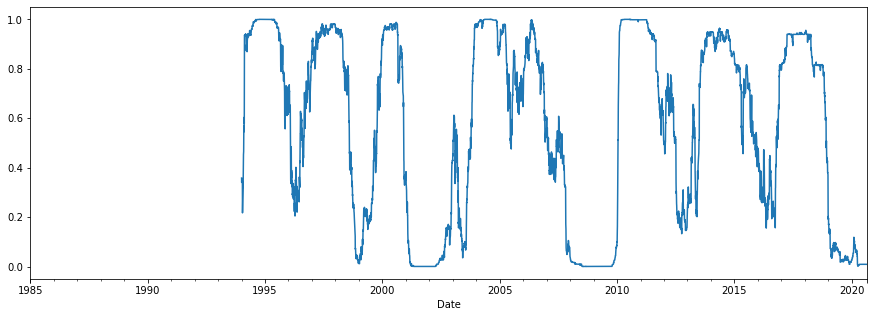

In [21]:
### TEMP

#df_iter_ptile['Level_Percentile'].plot(figsize = (15, 5))
df_iter_ptile['Momentum_Percentile'].plot(figsize = (15, 5))
#ser_change.dropna().hist()
#ser_ptile.plot(figsize = (15, 5))
#print(ser_iter_matrix.loc[All, '2020-08-31'].tail(10))#.resample('B').ffill()
#print(ser_iter_matrix.loc[All, '2020-08-31'].shift(1, freq = 'B').tail(10))

In [10]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE SAVING

dict_ptiles = {}
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Adding diagonal to collection:
    dict_ptiles[str_global_name] = pd.read_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key)
### Factors collection saving:
pd.concat(dict_ptiles, axis = 1).to_excel('Data_Files/Test_Files/Global_Percentiles.xlsx', merge_cells = False) 

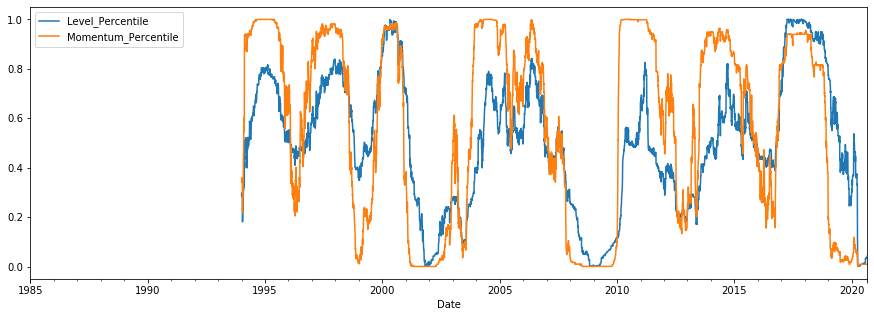

In [11]:
### TEMP

gc.collect()
#ser_test_matrix = ser_iter_matrix.loc[All, ['1994-01-07', '2020-08-31']]
#ser_iter_matrix.loc[All, '2020-08-31']
#df_iter_ptile['Momentum_Percentile'].plot(figsize = (15, 5))
#dict_ptiles['Inflation (YoY)'].plot(figsize = (15, 5))
dict_ptiles['Full Index (YoY)'].plot(figsize = (15, 5))

In [10]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE SIGN FACTORS GENERATING: RESEARCH VERSION

### Constants defining:
tumbler_to_minus = 0.60
tumbler_to_plus = 0.40
### Percentiles initialization:
dict_ptiles = {}

### Looping over global indices:
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Percentiles table reading:
    df_iter_combo = pd.read_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key)
    ### Looping over percentile types inside each global index:
    for str_ptile_type in df_iter_combo.columns:
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation started')
        ### Container initialization:
        dict_signs = {}
        ### Percentile extraction:
        ser_iter_ptile = df_iter_combo[str_ptile_type]
        ### Looping over dateline:
        for sign_date in ser_iter_ptile.dropna().index[-1 :]:
#            print(str_global_name, '/', str_ptile_type, '/', sign_date, ': Sign defining')
            ### Initial sign defining:
            ser_iter_signs = pd.Series(np.NaN, index = ser_iter_ptile.dropna()[ : sign_date].index)
            ser_iter_signs.name = 'Sign'
            ser_iter_signs.iloc[0] = 1         
            ### Looping over part of the timeseries till the sogn date to perform sign flipping:
            if (len(ser_iter_signs) > 1) :
                for iter_date in ser_iter_signs.index[1 : ]:
                    if (ser_iter_signs.loc[iter_date - pd.offsets.BusinessDay()] == 1):
                        if (ser_iter_ptile[iter_date] > tumbler_to_minus):
                            ser_iter_signs.loc[iter_date] = -1
                        else:
                            ser_iter_signs.loc[iter_date] = 1
                    else:
                        if (ser_iter_ptile[iter_date] < tumbler_to_plus):
                            ser_iter_signs.loc[iter_date] = 1
                        else:
                            ser_iter_signs.loc[iter_date] = -1
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation finished')           
        ### Signs vector collecting:
        dict_ptiles[str_global_name + ' / ' + str_ptile_type] = ser_iter_signs        
### Factors collection saving:
#pd.concat(dict_ptiles, axis = 1).to_hdf('Data_Files/Source_Files/Percentile_Signs_Research.hdf', key = 'percentile_signs', mode = 'a')
pd.concat(dict_ptiles, axis = 1).to_excel('Data_Files/Test_Files/Percentile_Signs_Research.xlsx', merge_cells = False)

Inflation (YoY) / Level_Percentile : Sign factors calculation started
Inflation (YoY) / Level_Percentile : Sign factors calculation finished
Inflation (YoY) / Momentum_Percentile : Sign factors calculation started
Inflation (YoY) / Momentum_Percentile : Sign factors calculation finished
Full Index (YoY) / Level_Percentile : Sign factors calculation started
Full Index (YoY) / Level_Percentile : Sign factors calculation finished
Full Index (YoY) / Momentum_Percentile : Sign factors calculation started
Full Index (YoY) / Momentum_Percentile : Sign factors calculation finished


In [ ]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE SIGN FACTORS GENERATING: DAY-BY-DAY VERSION

### Constants defining:
tumbler_to_minus = 0.60
tumbler_to_plus = 0.40
### Percentiles initialization:
dict_ptiles = {}

### Looping over global indices:
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Percentiles table reading:
    df_iter_combo = pd.read_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key)
    ### Looping over percentile types inside each global index:
    for str_ptile_type in df_iter_combo.columns:
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation started')
        ### Container initialization:
        dict_signs = {}
        ### Percentile extraction:
        ser_iter_ptile = df_iter_combo[str_ptile_type]
        ser_iter_res = pd.Series(np.NaN, index = ser_iter_ptile.dropna().index)
        ### Looping over dateline:
        for sign_date in ser_iter_ptile.dropna().index:
#            print(str_global_name, '/', str_ptile_type, '/', sign_date, ': Sign defining')
            ### Initial sign defining:
            ser_iter_signs = pd.Series(np.NaN, index = ser_iter_ptile.dropna()[ : sign_date].index)
            ser_iter_signs.name = 'Sign'
            ser_iter_signs.iloc[0] = 1         
            ### Looping over part of the timeseries till the sogn date to perform sign flipping:
            if (len(ser_iter_signs) > 1) :
                for iter_date in ser_iter_signs.index[1 : ]:
                    if (ser_iter_signs.loc[iter_date - pd.offsets.BusinessDay()] == 1):
                        if (ser_iter_ptile[iter_date] > tumbler_to_minus):
                            ser_iter_signs.loc[iter_date] = -1
                        else:
                            ser_iter_signs.loc[iter_date] = 1
                    else:
                        if (ser_iter_ptile[iter_date] < tumbler_to_plus):
                            ser_iter_signs.loc[iter_date] = 1
                        else:
                            ser_iter_signs.loc[iter_date] = -1
            ser_iter_res[sign_date] = ser_iter_signs[sign_date]
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation finished') 
        ### Signs vector collecting:
        dict_ptiles[str_global_name + ' / ' + str_ptile_type] = ser_iter_res
### Factors collection saving:
#pd.concat(dict_ptiles, axis = 1).to_hdf('Data_Files/Source_Files/Percentile_Signs_Daily.hdf', key = 'percentile_signs', mode = 'a')
#pd.concat(dict_ptiles, axis = 1).to_excel('Data_Files/Test_Files/Percentile_Signs_Daily.xlsx', merge_cells = False)